# Miniproject: Landing on the Moon

## ============================ **README** ============================

_Team members_ [sciper]: Thomas Benchetrit [284001], Eliott Zemour [283174]  
This is our submission for miniproject 1 of the ANN course.
Each experiment presented in the report have been run for 6000 episodes and stored in csv files. If necessary, we would be glad to provide our results.
## ================================================================

## Introduction

### Description

Traditionally, reinforcement learning has operated on "tabular" state spaces, e.g. "State 1", "State 2", "State 3" etc. However, many important and interesting reinforcement learning problems (like moving robot arms or playing Atari games) are based on either continuous or very high-dimensional state spaces (like robot joint angles or pixels). Deep neural networks constitute one method for learning a value function or policy from continuous and high-dimensional observations. 

In this miniproject, you will teach an agent to play the Lunar Lander game from [OpenAI Gym](https://gym.openai.com/envs/LunarLander-v2/). The agent needs to learn how to land a lunar module safely on the surface of the moon. The state space is 8-dimensional and (mostly) continuous, consisting of the X and Y coordinates, the X and Y velocity, the angle, and the angular velocity of the lander, and two booleans indicating whether the left and right leg of the lander have landed on the moon.

The agent gets a reward of +100 for landing safely and -100 for crashing. In addition, it receives "shaping" rewards at every step. It receives positive rewards for moving closer to [0,0], decreasing in velocity, shifting to an upright angle and touching the lander legs on the moon. It receives negative rewards for moving away from the landing site, increasing in velocity, turning sideways, taking the lander legs off the moon and for using fuel (firing the thrusters). The best score an agent can achieve in an episode is about +250.

There are two versions of the task: one with discrete controls and one with continuous controls but we'll only work with the discrete version. In the discrete version, the agent can take one of four actions at each time step: [do nothing, fire engines left, fire engines right, fire engines down]. 

We will use Policy Gradient approaches (using the REINFORCE rule) to learn the task. As you remember, in standard supervised learning tasks (e.g. image classification), the network generates a probability distribution over the outputs, and is trained to maximize the probability of a specific target output given an observation (input). In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation.

### Questions
**Question 1**. Suppose that you are designing the environment rewards yourself. Why do you think it is a good idea to have rewards in addition to the +100 reward for safe landing (e.g. for moving closer / further from [0, 0], for touching the lander legs on the moon)? One might say that if we only have a final reward, the agent will still be able to learn how to reach it. What will be the problem here?

**Answer**:  
If we only give to the module the final reward of +100, the model will not have sufficient information to update the parameters. Moreover, as the +100 reward will happen very scarcely, the model will learn extremely slowly. By having intermediate small rewards, the module can learn by each step.

**Question 2**. Now suppose you decide to give the agent a small reward if it moves closer to the landing point but you forget to penalize it when it moves away from it. What kinds of strange behaviour you may observe from the trained agent?

**Answer**:  
We can imagine that the agent will (over)exploit this reward by going back and forth many times in order to obtain the very same reward each 2 moves. Therefore, it is likely that the gradient ascent for updating the parameters will more often be stuck in a local maxima.


## Dependencies Setup
Please run the following cell to install the required packages. Note that you may be asked to restart the notebook. After restarting and reruning the cells, everything should work.

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip3 install box2d-py > /dev/null 2>&1
!pip3 install gym[Box_2D] pyvirtualdisplay > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

### Your Names

Before you start, please enter your sciper number(s) in the field below; they are used to load the data.

In [ ]:
sciper = {'student_1': 0, 
          'student_2': 0}
seed = sciper['student_1']+sciper['student_2']

## Setup

### Dependencies and constants

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import logging
import io
import base64

from IPython import display as ipythondisplay
from IPython.display import HTML, clear_output

from matplotlib.animation import FuncAnimation
from pyvirtualdisplay import Display
from gym.envs.box2d.lunar_lander import heuristic
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
import keras
import tensorflow as tf
# from tensorflow_probability.distributions import Beta
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(seed)
tf.random.set_seed(seed*2)

### Gym Setup

Here we load the Reinforcement Learning environments from Gym.

We limit each episode to 500 steps so that we can train faster. 

In [ ]:
gym.logger.setLevel(logging.ERROR)
discrete_env = gym.make('LunarLander-v2')
discrete_env._max_episode_steps = 500
discrete_env.seed(seed*3)
gym.logger.setLevel(logging.WARN)

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["animation.html"] = "jshtml"

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, we will use the `Results` class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with `results.save('filename')` and reload them with `Results(filename='filename')`. Use `results.pop(experiment_name)` to delete an old experiment.

In [ ]:
def AddValue(output_size, value):
    return Lambda(lambda x: x + value, output_shape=(output_size,))

def render(episode, env):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html

class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super().__init__(data)
        else:
            super().__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [1]:
num_episodes = 6000

def run_experiment(experiment_name, 
                   env, 
                   num_episodes, 
                   policy_learning_rate=0.001, 
                   value_learning_rate=0.001, 
                   baseline=None, 
                   entropy_cost=0, 
                   max_ent_cost=0, 
                   num_layers=3):

    #Initiate the learning agent
    agent = RLAgent(n_obs=env.observation_space.shape[0], 
                    action_space=env.action_space,
                    policy_learning_rate=policy_learning_rate, 
                    value_learning_rate=value_learning_rate, 
                    discount=0.99, 
                    baseline=baseline, 
                    entropy_cost=entropy_cost, 
                    max_ent_cost=max_ent_cost,
                    num_layers=num_layers)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 50 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(50)
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an action based on the observations
            action = agent.decide(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            # Reset for next step
            observation = next_observation
            step += 1
            
    return all_episode_frames, agent

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). We'll modify this class to add additional methods and functionality throughout the course of the miniproject.


In [ ]:
class RLAgent(object):
    
    def __init__(self, n_obs, action_space, policy_learning_rate, value_learning_rate, 
                 discount, baseline = None, entropy_cost = 0, max_ent_cost = 0, num_layers = 3):

        #We need the state and action dimensions to build the network
        self.n_obs = n_obs  
        self.n_act = action_space
        
        self.plr = policy_learning_rate
        self.vlr = value_learning_rate
        self.gamma = discount
        self.entropy_cost = entropy_cost
        self.max_ent_cost = max_ent_cost
        self.num_layers = num_layers
        
        #<add code here>
        self.baseline = baseline
        self.moving_av = 0.0

        #These lists stores the cumulative observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        #Build the keras network
        
        if self.baseline == 'adaptive':
          self.model ,  self.value_model = self._build_network()
        else :
          self.model = self._build_network()

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above."""
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        state = np.asarray(state).reshape(1,8)
        distrib = self.model(state).numpy().reshape(-1).astype('float64')
        distrib = distrib/distrib.sum()
        action = np.random.choice(4, 1, p=distrib)[0]
        return action # returns 0,1,2,3

    def train(self, N):
        """ When this function is called, the accumulated episode observations, actions and discounted rewards
            should be fed into the network and used for training. Use the _get_returns function to first turn 
            the episode rewards into discounted returns. 
            Apply simple or adaptive baselines if needed, depending on parameters."""

        action = self.episode_actions
        n = len(action)
        observations = np.asarray(self.episode_observations)
        output = np.zeros((n,4))
        g = np.asarray(self._get_returns()).reshape(-1,1)

    
        if self.baseline == "simple" :
          mean_returns = np.mean(g)
          self.moving_av = mean_returns * 2/(1+N) + self.moving_av * (1 - 2/(1+N)) # exponential moving average
          g -= self.moving_av

        if self.baseline == 'adaptive':
          v = np.array([self.value_model(np.array(observations[i]).reshape(1,8)) for i in range(n)]).reshape(-1,1)
          self.value_model.train_on_batch(observations,g) 
          g = np.subtract(g,v)

        for i in range(n): 
          output[i,action[i]] = 1
        weights  = np.asarray([g[i] * self.gamma**i for i in range(n)])
        self.model.train_on_batch(observations,output,sample_weight = weights)
        self.episode_actions = []
        self.episode_observations = []
        self.episode_rewards = []

    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode. Hint: work backwards."""

        # Goes from self.episode_rewards = [r1, ... rT]
        # to returns = [..., rt-2 + gamma*rt-1 + gamma^2*rt,  rt-1 + gamma*rt, rt]
        returns = [self.episode_rewards[-1]]
        for reward in reversed(self.episode_rewards[:-1]):
          returns.insert(0, reward + self.gamma*returns[0])
        return returns

    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""

        act = "relu"                        # ReLU activation function
        loss = "categorical_crossentropy"   # Keras built-in "categorical cross-entropy" loss
        init_kr ='glorot_uniform'
        input_dim = 8                       # 8-dimensional state space as input
        out_dim = 4                         # softmax distribution over the 4 discrete actions
        optimizer = keras.optimizers.Adam(learning_rate = self.plr)
        optimizer_value = keras.optimizers.Adam(learning_rate = self.vlr)
        model = Sequential()
        model.add(Input(shape=(input_dim,)))
        for i in range(self.num_layers):
          model.add(Dense(16, activation = act, name = "hidden"+str(i+1), kernel_initializer= init_kr))
        model.add(Dense(out_dim, activation = "softmax", name = "output", kernel_initializer= init_kr))

        model.compile(loss = loss, optimizer = optimizer)

        if self.baseline == 'adaptive':
          value_model = Sequential()
          value_model.add(Input(shape=(input_dim,)))
          for i in range(self.num_layers):
            value_model.add(Dense(16, activation = act, name = "hidden"+str(i+1), kernel_initializer= init_kr))
          value_model.add(Dense(1, name = "output", kernel_initializer= init_kr))
          value_model.compile(loss = 'mean_squared_error', optimizer = optimizer_value)
          return model , value_model
        else : 
          return model

## Exercise 1: REINFORCE with simple baseline

### Description

Implement the REINFORCE Policy Gradient algorithm using a deep neural network as a function approximator.

1. Implement the `observe` method of the RLAgent above.
2. Implement the `_build_network` method. Your network should take the 8-dimensional state space as input and output a softmax distribution over the 4 discrete actions. It should have 3 hidden layers with 16 units each with ReLU activations. Use the REINFORCE loss function. HINT: Keras has a built-in "categorical cross-entropy" loss, and a `sample_weight` argument in fit/train_on_batch. Consider how these could be used together.
3. Implement the `decide`, `train` and `_get_returns` methods using the inputs and outputs of your network. In `train`, implement a baseline based on a moving average (over episodes) of the mean returns (over trials of one episode); it should only be in effect when the agent is constructed with the `use_simple_baseline` keyword. Also, use `train_on_batch` to form one minibatch from all the experiences in an episode. Hint: see Question 2) below.
4. Try a few learning rates and pick the best one (the default for Adam is a good place to start). Run the functions below and include the resulting plots, with and without the baseline, for your chosen learning rate. 
5. Answer the questions below in max. 1-2 sentence(s).

WARNING: Running any experiments with the same names (first argument in run_experiment) will cause your results to be overwritten. 

**Mark breakdown: 7 points total**
- 5 points for implementing and plotting basic REINFORCE with reasonable performance (i.e. a positive score) and answering the questions below.
- 2 points for implementing and plotting the simple baseline with reasonable performance.

### Solution

In [ ]:
# code to produce the figures

# REINFORCE with EMA simple baseline:
results = Results()
policy_learning_rate = 0.001
episodes, agent = run_experiment("REINFORCE_simple_ema_0.001", discrete_env, num_episodes, policy_learning_rate, baseline = 'simple')

# REINFORCE without baseline
results = Results()
policy_learning_rate = 0.002
episodes, agent = run_experiment("REINFORCE_no_baseline_0.002", discrete_env, num_episodes, policy_learning_rate, baseline='none')

**Moving average for the simple baseline**:  
The exponential moving average (EMA) is implemented as a baseline for REINFORCE. It is computed as follows:  
Given the array of discounted rewards obtained during one episode with `self._get_returns()`, the mean return over episode $n$ is computed with `mean_return = np.mean(self._get_returns())`. Then, the EMA of episode $N$ is updated as:
$$
\text{EMA} = \text{mean_return}\, \cdot \frac{2}{1+N}\; + \; \text{EMA}\,\cdot \bigg( 1 - \frac{2}{1+N}\bigg)
$$

_source for the EMA formula: https://www.investopedia.com/terms/e/ema.asp_.


**Plots**:
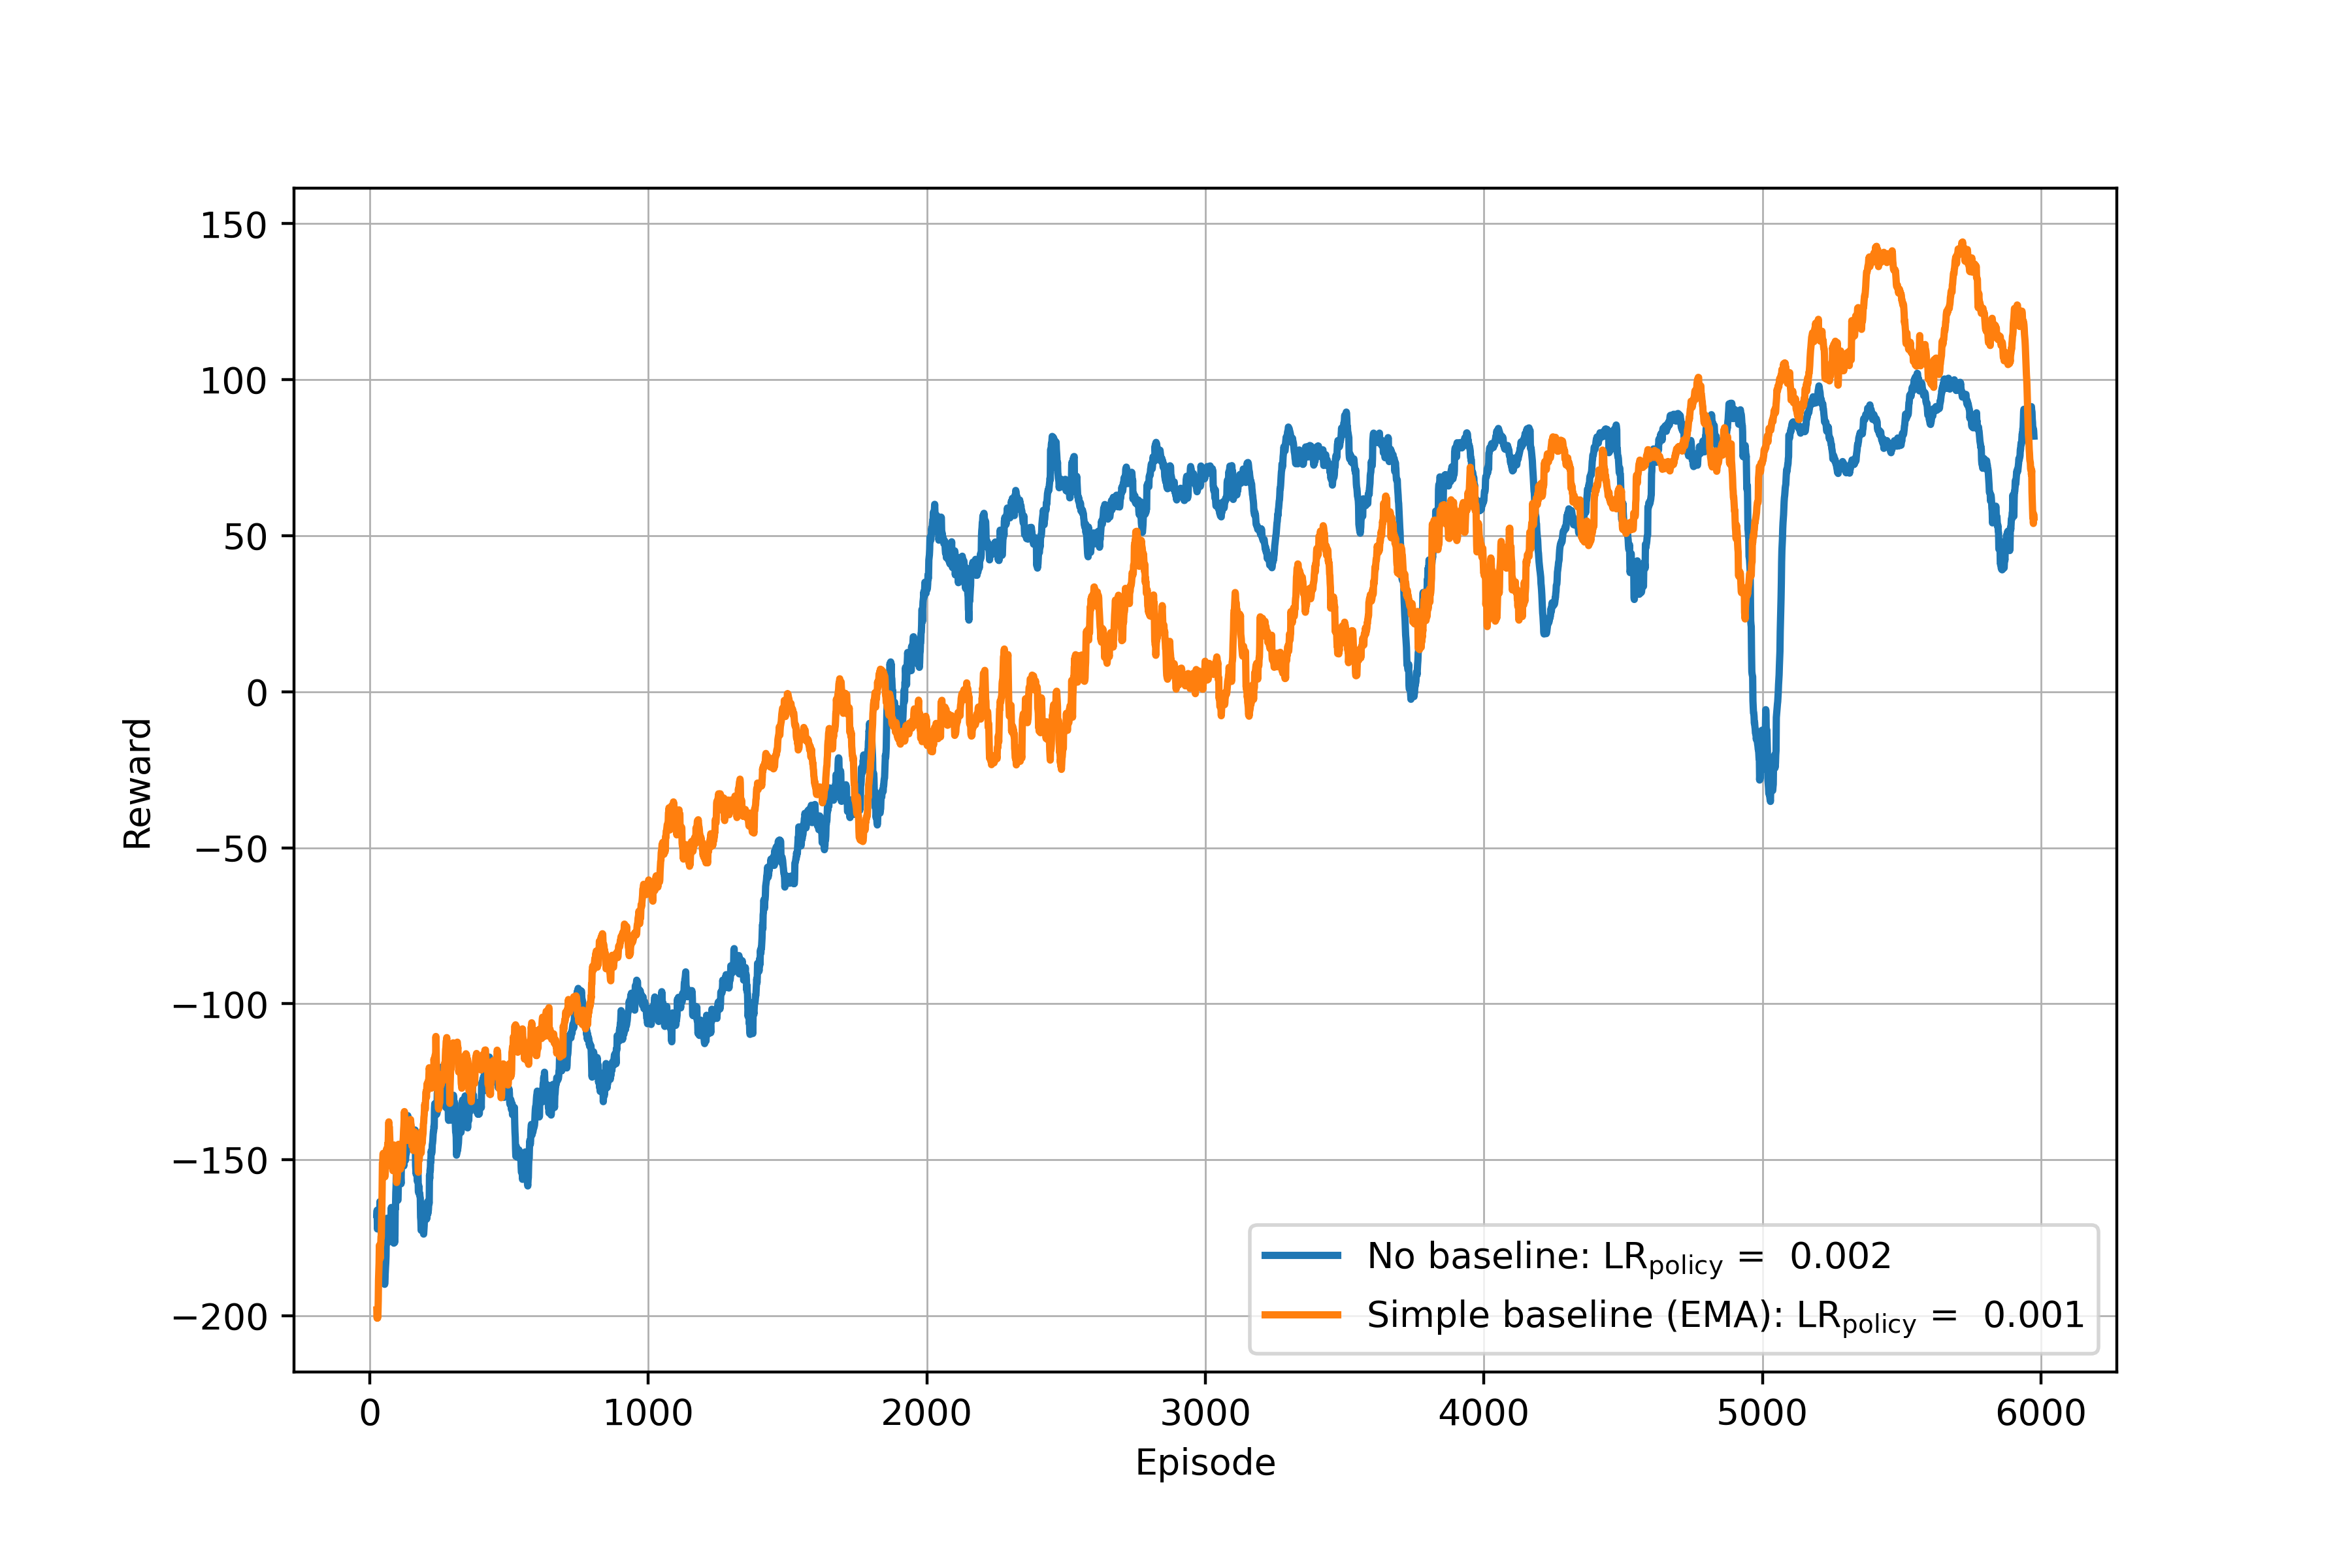

*Description of the figure*: On the above figure, the rewards collected by the agent are shown over 6000 episodes. The blue line represents an agent trained without any baseline (i.e basic REINFORCE), with a learning rate chosen at 0.002. The simple baseline - implemented with an exponential moving average (EMA) - is represented by the orange line and the learning rate is 0.001.  
Convolutional window used: 50 (i.e the call to the plot function is `results.plot(50)`).


**Question 1**: We have at least three posibilities of picking the action: i) sample an action according to the softmax distribution, ii) select action with max action probability and iii) use an epsilon-greedy strategy. What is the difference between these strategies and which one(s) is(are) preferable during training and which one(s) is(are) preferable during testing?. 


**Answer**:  
- During **training**, the softmax (i) and epsilon-greedy (ii) strategies are preferable since they both allow for **exploration**, which is a desirable behavior in order to achieve the maximum performance. Indeed, they both involve randomness in their action selection, which can prevent the agent from being stuck in a local maxima. The greedy strategy is not a good strategy to adopt for training because it will lead to a performance almost entirely determined by the few first episodes of the agent (reinforcing loop).  
The epsilon-greedy policy is such that it chooses a random action with probability epsilon, but in this case, it chooses uniformly any action, regardless of their quality suggested by the network. In the case of the softmax policy, the randomness is always used but the probabilities of selecting an action are influenced by the model. Still, these two strategies are not completely random and they also allow for **exploitation**. The balance between the exploration and exploitation behavior is crucial for the training procedure. 

- During **testing**, the greedy strategy is preferable because we are now interested in obtaining the best possible performance over a given testing example. This is done by exploiting what the model have learnt to be best during the training process. That is exactly the purpose of the greedy policy: select the action with max action probability.


**Question 2**: In the train method above we throw away the data from an episode after we use it to train the network (make sure that you do that). Why is it not a good idea to keep the old episodes and train the policy network on both old and new data? (Note: Reusing data can still be possible but requires modifications to the REINFORCE algorithm that we are using).

**Answer**:  
If we do not throw away the data of previous episodes, that means that we train on every episode since the beginning of the training. Therefore, each return of each episode will be discounted a lot and the discounted return will tend to 0 after a few episodes. That means that after some episodes, the model will stop to learn from the new episodes.

## Exercise 2: Adaptive baseline
### Description

Add a second neural network to your model that learns an observations-dependent adaptive baseline and subtracts it from your discounted returns.

1. Modify the `_build_network` function of RLAgent to create a second "value network" when `adaptive` is passed for the baseline argument. The value network should have the same or similar structure as the policy network, without the softmax at the output.
3. In addition to training your policy network, train the value network on the Mean-Squared Error compared to the discounted returns.
4. Train your policy network on $R - b(s)$, i.e. the returns minus the adaptive baseline (the output of the value network). Your implementation should allow for a different learning rate for the value and policy network.
5. Try a few learning rates and plot all your best results together (without baseline, with simple baseline, with adaptive baseline). You may or may not be able to improve on the simple baseline! Return the trained model to use it in the next exercise.

TECHNICAL NOTE: Some textbooks may refer to this approach as "Actor-Critic", where the policy network is the "Actor" and the value network is the "Critic". Sutton and Barto (2018) suggest that Actor-Critic only applies when the discounted returns are bootstrapped from the value network output, as you saw in class. This can introduce instability in learning that needs to be addressed with more advanced techniques, so we won't use it for this miniproject. You can read more about state-of-the-art Actor-Critic approaches here: https://arxiv.org/pdf/1602.01783.pdf

**Mark breakdown: 3 points total**
- 3 points for implementing and plotting the adaptive baseline with the other two conditions, with reasonable performance (i.e. at least similar to the performance in Exercise 1).

### Solution

In [ ]:
# code to produce the plot
value_learning_rate = 0.002
policy_learning_rate = 0.002
episodes, d_model = run_experiment("REINFORCE (adaptive baseline)", discrete_env, num_episodes, policy_learning_rate, 
                                   value_learning_rate, baseline='adaptive')

**Plot (for adaptive baseline only):**
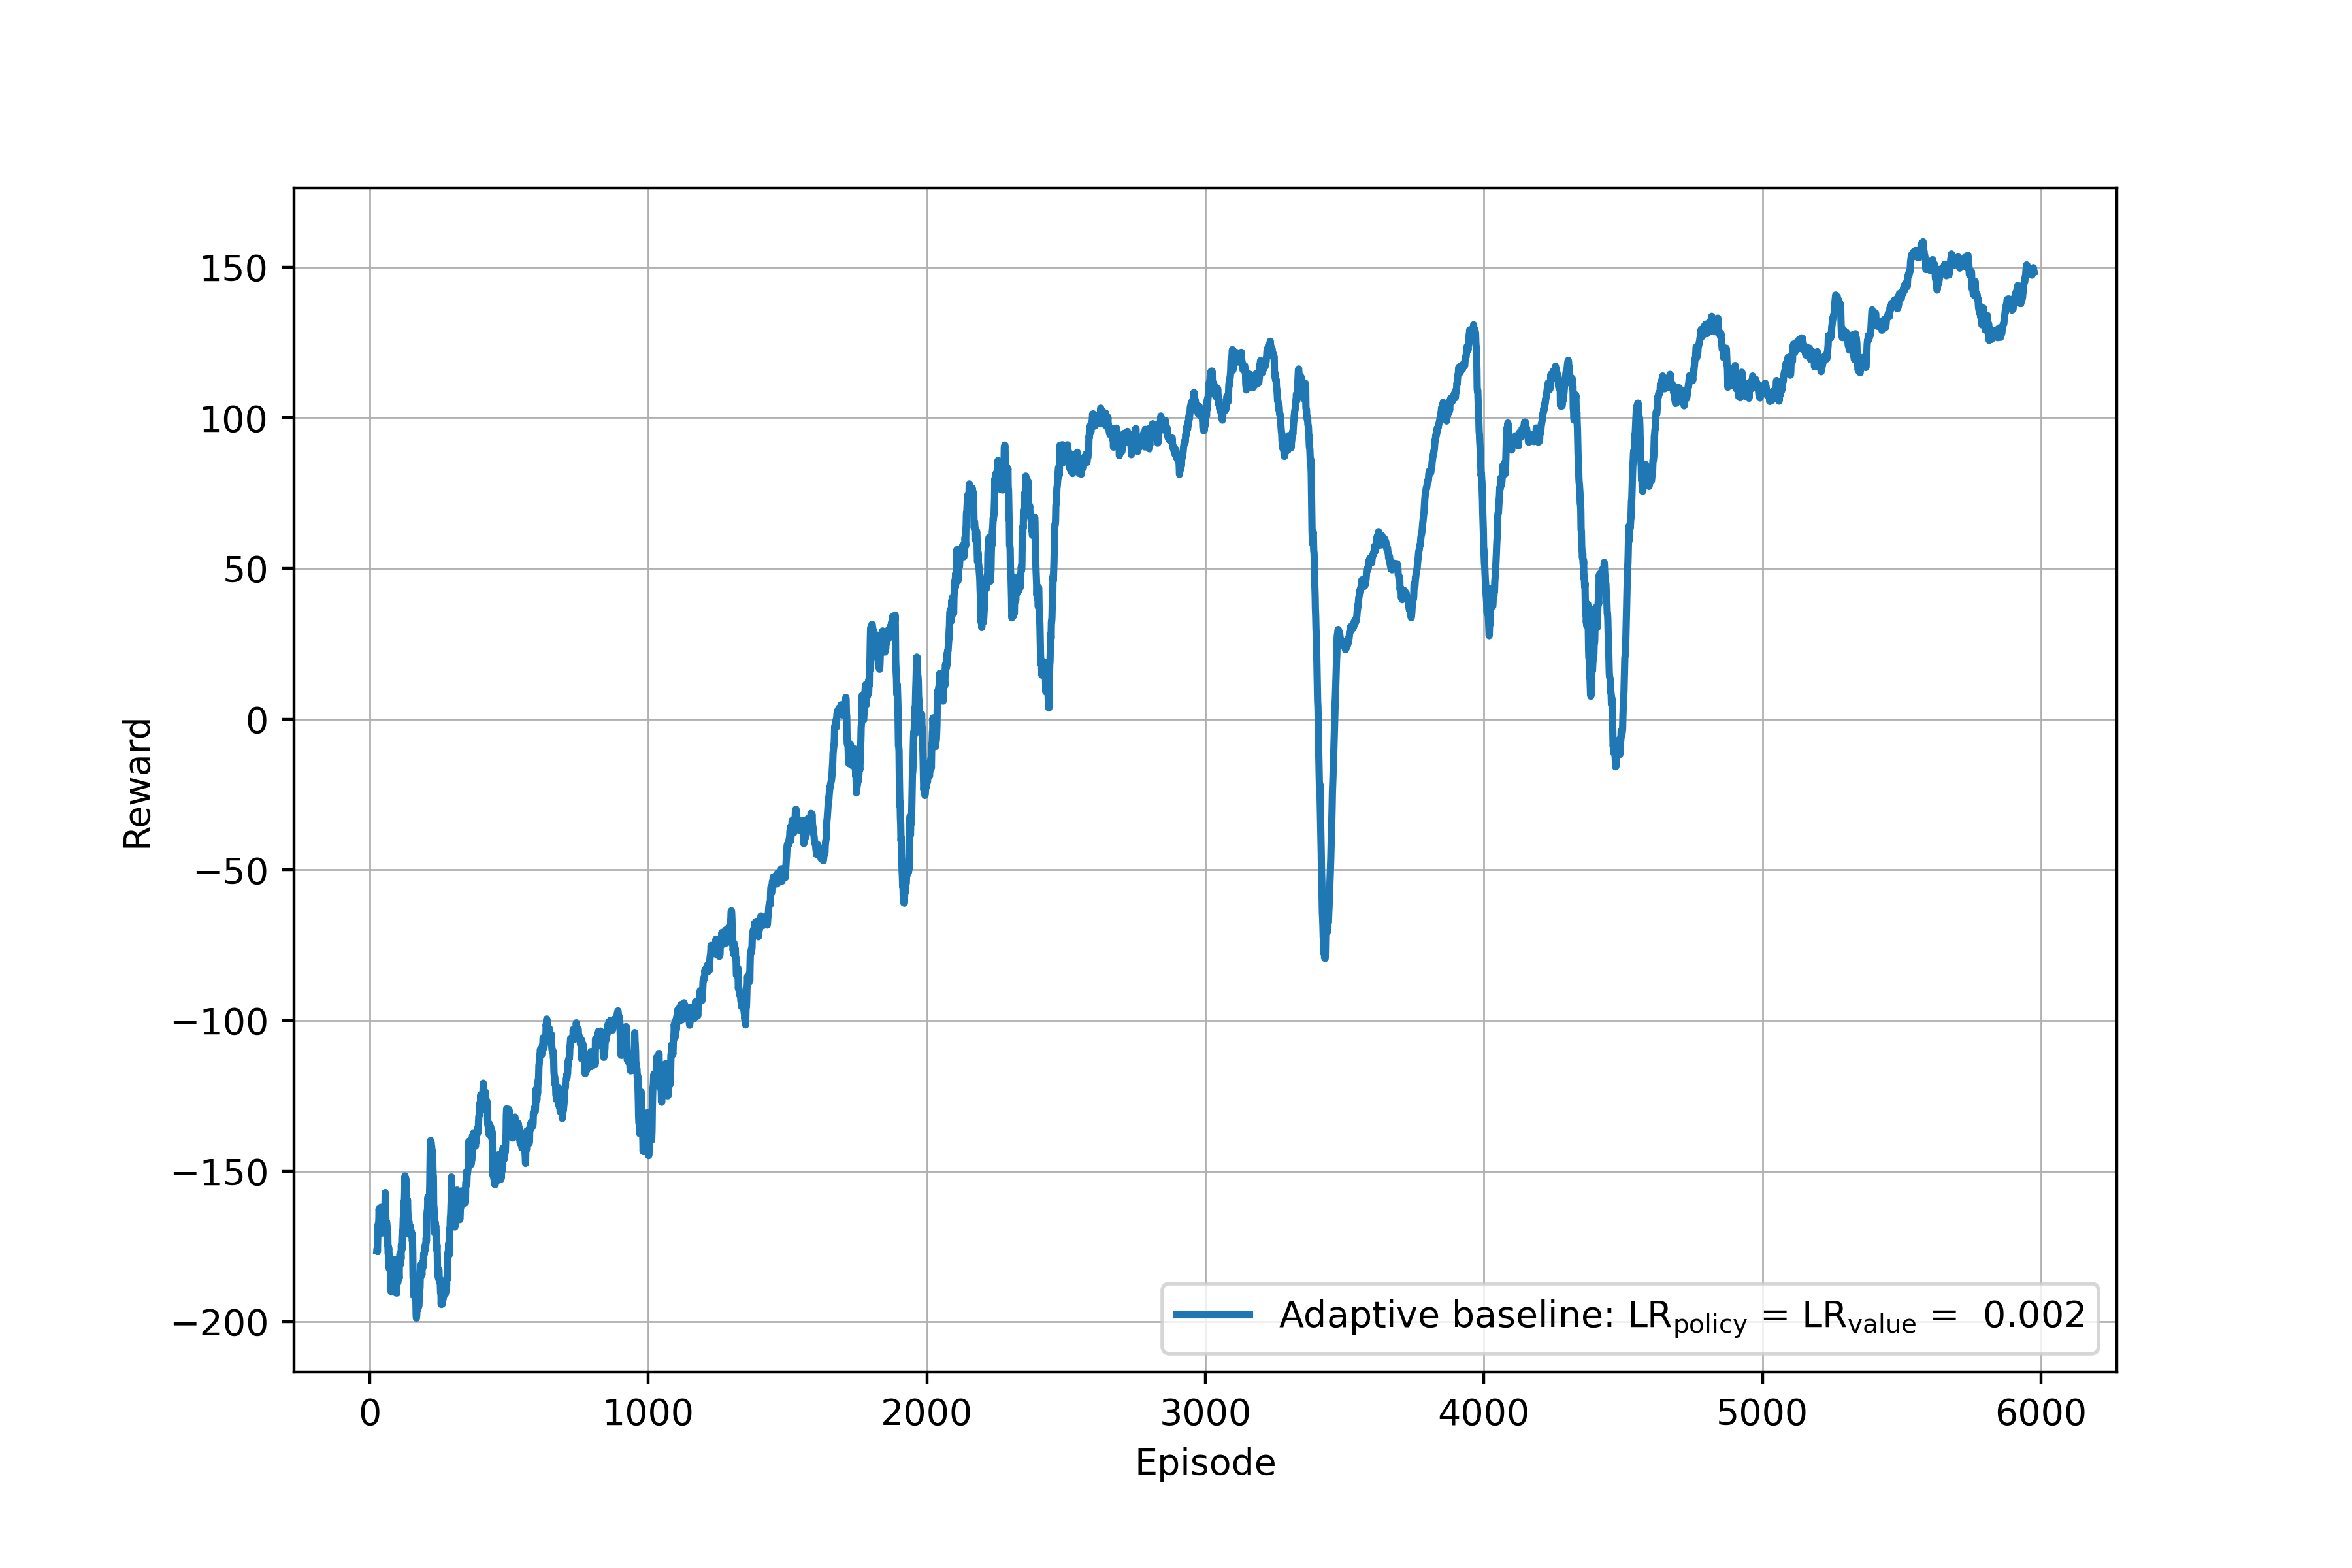

*Description of the figure*: On the above figure, the rewards collected by the agent are shown over 6000 episodes. The adaptive baseline is implemented with one network for the value function. Both learning rates for the policy and value are 0.002.  
Convolutional window used: 50 (i.e the call to the plot function is `results.plot(50)`).


**Plot (with comparison no/simple/adaptive):**
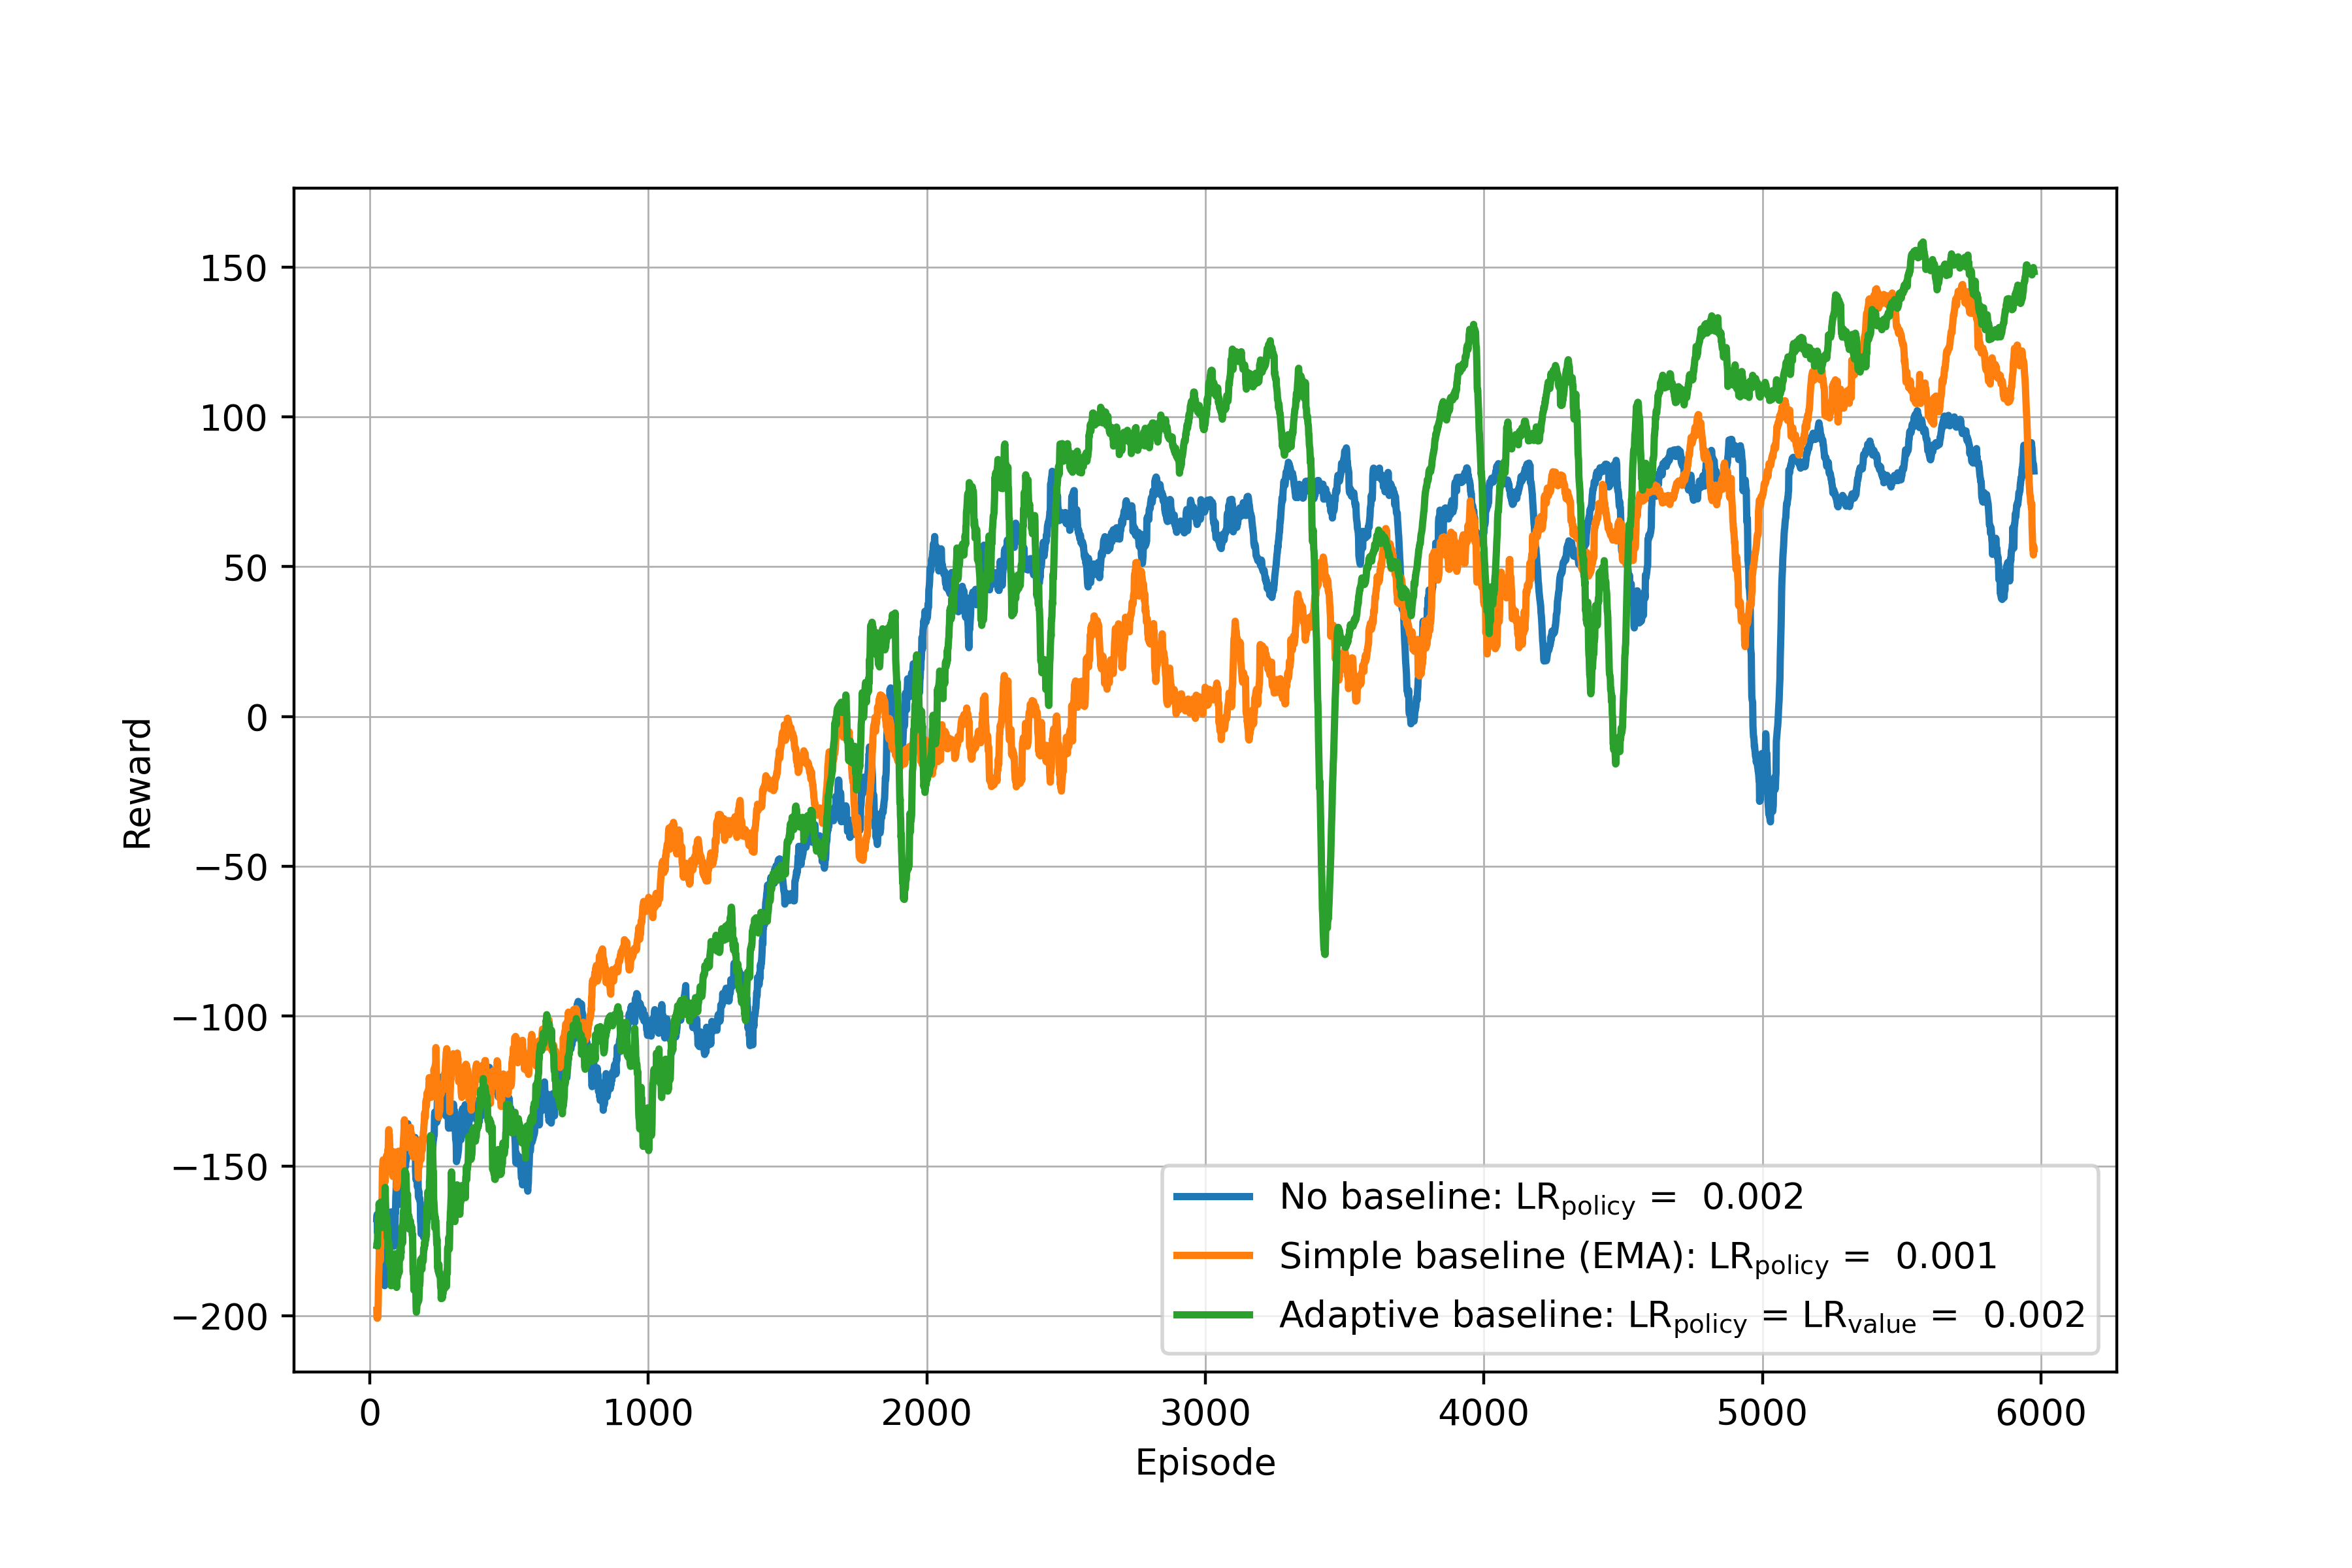

*Description of the figure*: Comparison between the different baselines and their best learning rates found.The adaptive baseline shows a better performance around episodes 3000 & 6000. However, the simple baseline is better for early results, probably because the adaptive one needs more time to train its two neural networks. The agent trained with no baseline struggles improving its performance after 3000 episodes.    
Convolutional window used: 50 (i.e the call to the plot function is `results.plot(50)`).

## Exercise 3: Visualizing the Value Function

### Description

Ideally, our value network should have learned to predict the relative values across the input space. We can test this by plotting the value prediction for different observations.

1. Write a function to plot the value network prediction across [x,y] space for given (constant) values of the other state variables. X is always in [-1,1], and Y generally lies in [-0.2,1], where the landing pad is at [0,0]. (`plt.imshow`, `plt.title`, and `plt.colorbar` can be useful)
2. Plot (with titles specifying the state variable combinations) the values for 5-6 combinations of the other 6 state variables, including [0,0,0,0,0,0]. The X and Y velocity are generally within [-1,1], the angle is in [-pi,pi] and the angular velocity lies roughly within [-3,3]. The last two inputs indicating whether the legs have touched the ground are 0 (False) or 1 (True). Include two combinations with (one of the) state variables out of these ranges. Use the same color bar limits across the graphs so that they can be compared easily. 
3. Answer the question below in max. 2-3 sentence(s).

**Mark breakdown: 3 points total**
- 3 points for the plots of the value function and answering the question below.

### Solution

In [ ]:
# method for the value function plot
def plot_value_function(agent, n ) : 
  value_model = agent.value_model
  Y = np.linspace(1,-0.2, num = n)
  X = np.linspace(-1,1, num = n)
  resultat = np.ones((n,n))
  Xg, Yg = np.meshgrid(X, Y) 
  for i in range(n):
    for j in range(n):
      pred = value_model(np.array([X[i],Y[j],0,0,0,0,0,0]).reshape(1,-1))
      resultat[i ,j] = pred
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.pcolor(Xg.transpose(), Yg.transpose(), resultat, cmap='jet')
  cbar = plt.colorbar()
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax.set_aspect('equal', adjustable='box')
  plt.title('Value ')
  plt.show()
  combi1 = [0,0,0,0,0,0,0,0]
  combi2 = [0,0,-0.5,0.5,-0.12,2,1,1]
  combi3 = [0.8,1.1,0,-0.9,0.5,-1,0,0]
  combi4 = [-0.3,1.5,0,0,0,0,0,0]
  combi5 = [0,-0.3,0,0,0,0,1,1]
  combi6 = [0.05,2,0.2,-1,0.5,0.6,0,0]

  all_combi = [combi1,combi2,combi3,combi4,combi5,combi6]
  all_combi = [np.array(combi).reshape(1,-1)for combi in all_combi]
  for combi in all_combi:
    print("For the combinaison of variable {0}, the value function gives {1}".format(combi,value_model(combi)))

In [ ]:
# code for this part
results = Results()
policy_learning_rate = 0.002
value_learning_rate = 0.002
episodes, agent = run_experiment("REINFORCE_adaptive", discrete_env, num_episodes, policy_learning_rate,value_learning_rate, baseline='adaptive')
plot_value_function(agent,50)

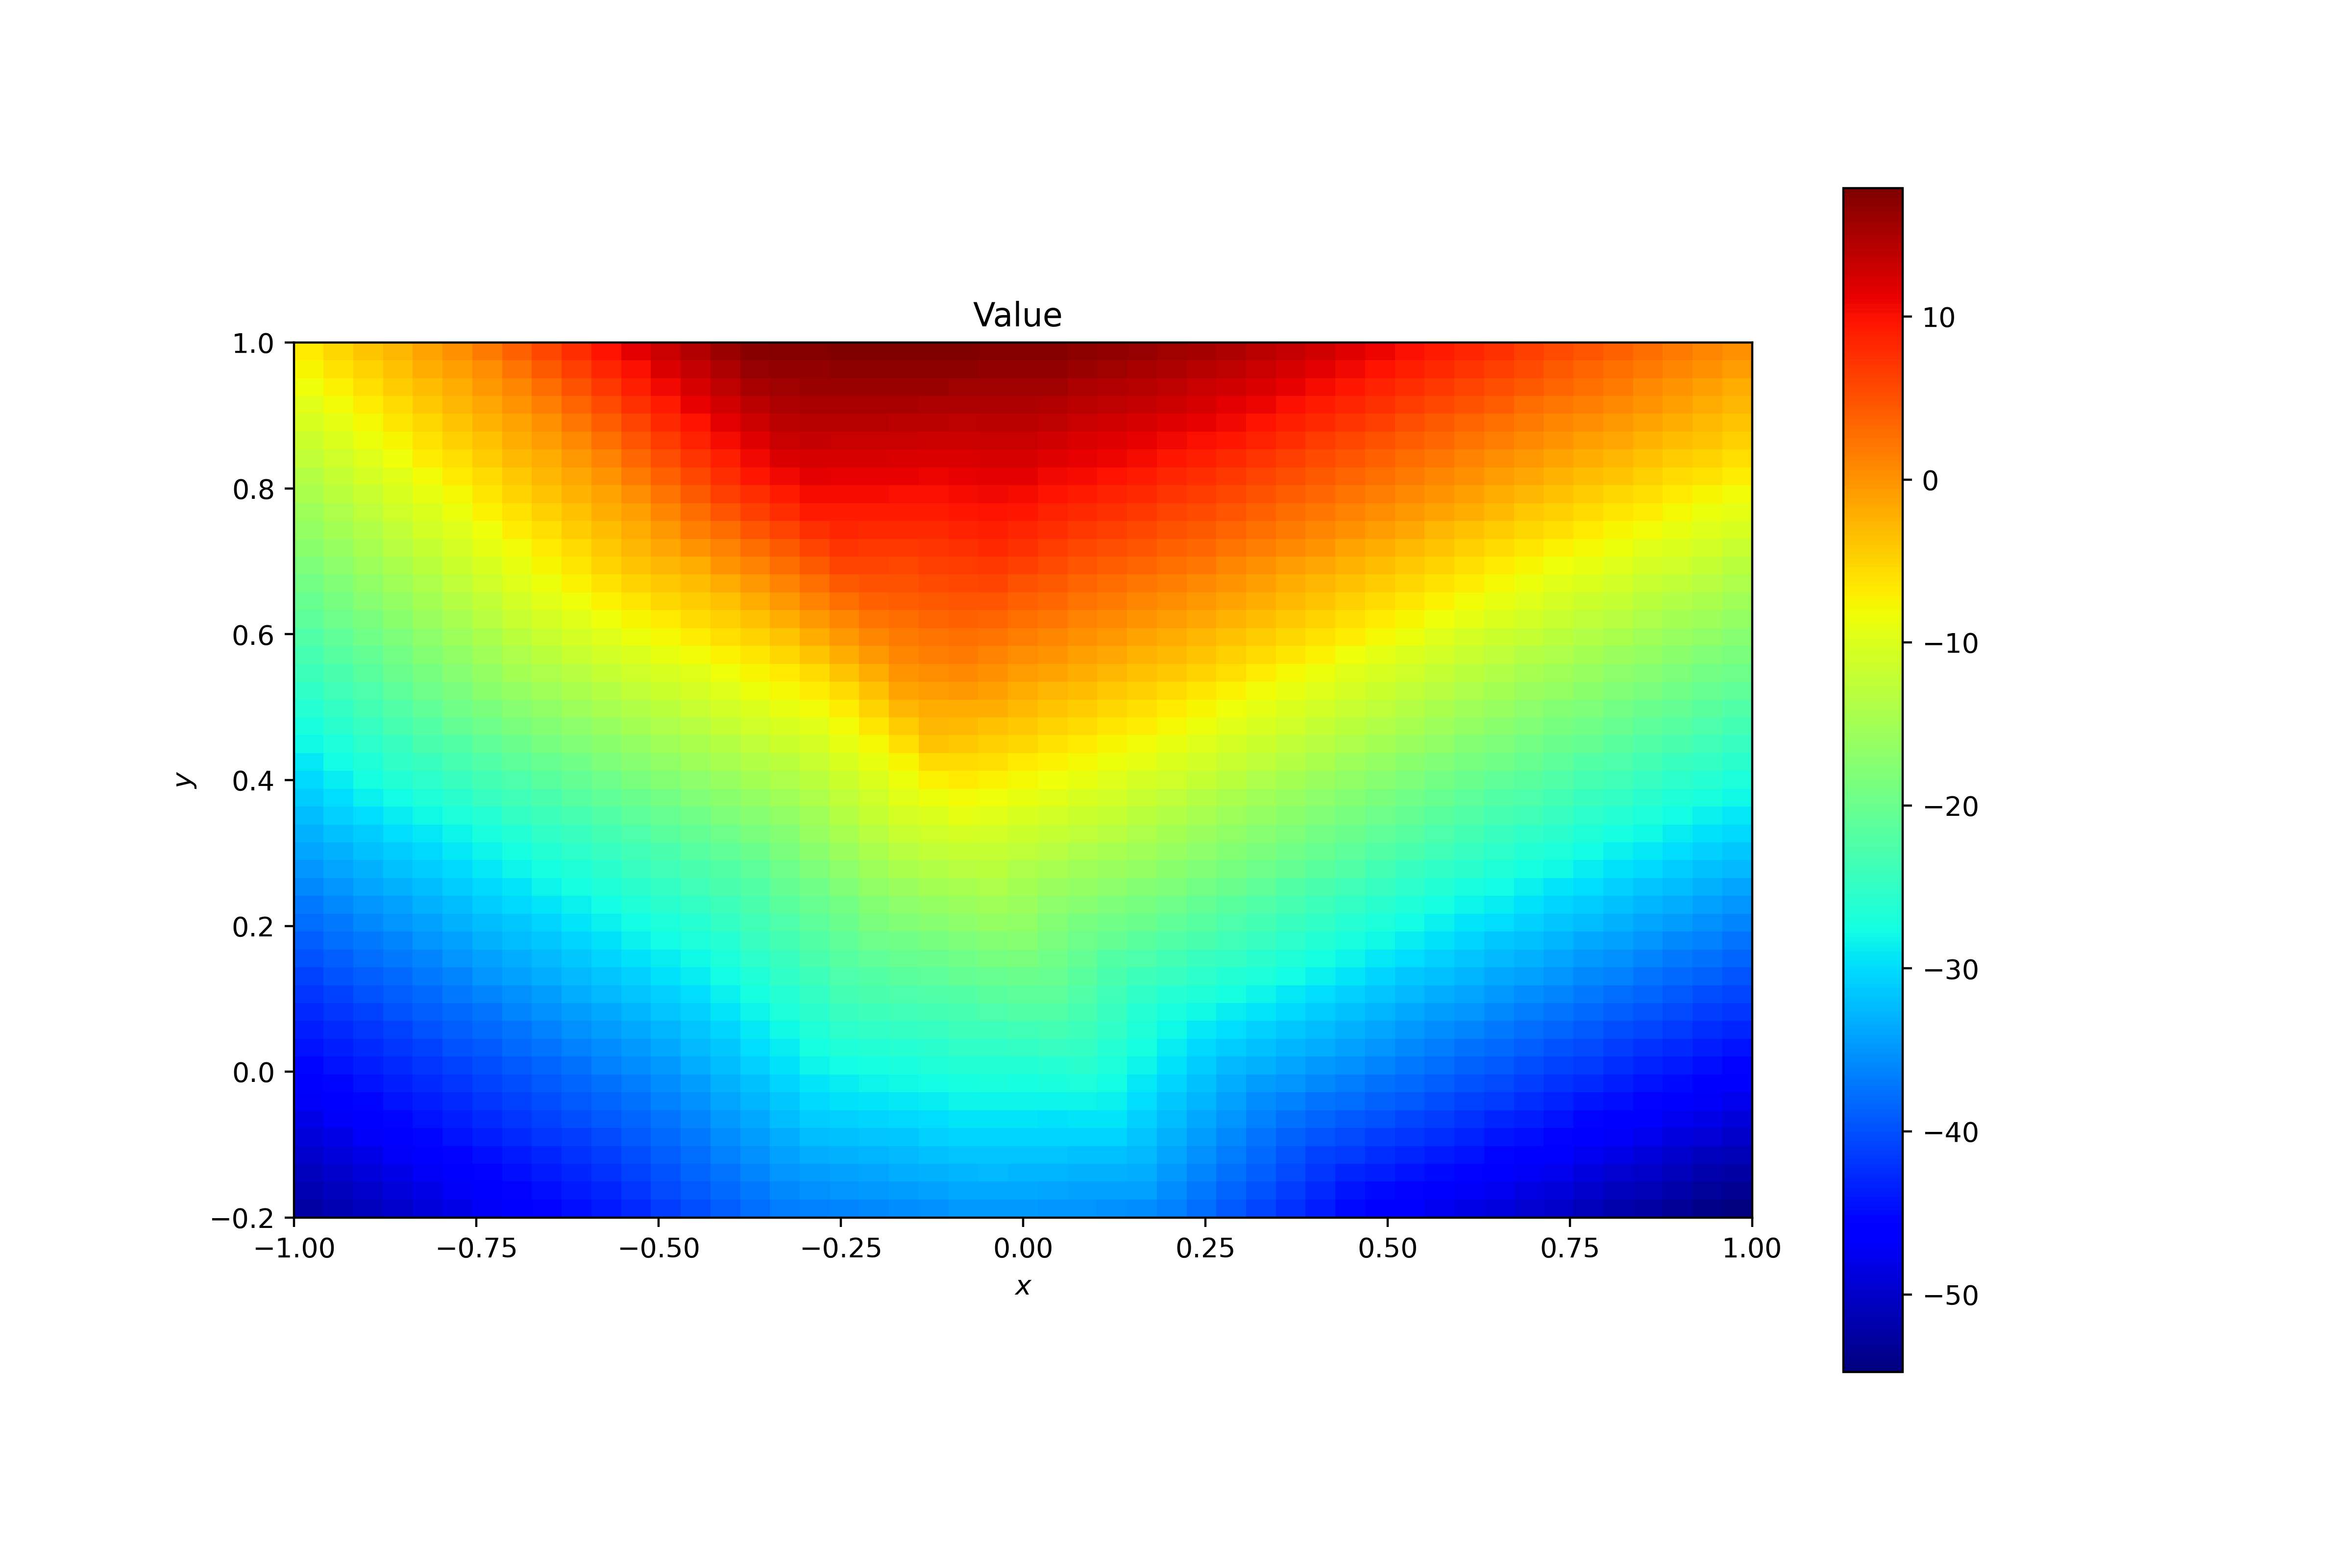

**Discussion** : 
The value function was ploted withe varying x and y coordinates, and 0 for all the other parameters.

From the plot, one can say that the neural network used to approximate the value function succeeded at its task. Indeed, by looking at the plot, it seems like the closer we get to the [0.0,0.0] coordinate, the margin of error for the lander shrinks, in order for it to learn to land exactly in the [0.0,0.0] coordinate.

For the combinaison of variable [[0 0 0 0 0 0 0 0]], the value function gives [[-27.049501]] \\
For the combinaison of variable [[ 0.    0.   -0.5   0.5  -0.12  2.    1.    1.  ]], the value function gives [[-85.82571]] \\
For the combinaison of variable [[ 0.8  1.1  0.  -0.9  0.5 -1.   0.   0. ]], the value function gives [[54.97489]] \\
For the combinaison of variable [[-0.3  1.5  0.   0.   0.   0.   0.   0. ]], the value function gives [[29.176561]] \\
For the combinaison of variable [[0,-0.3,0,0,0,0,1,1]] the value function gives [[-75.052684]] \\
For the combinaison of variable [[0.05,2,0.2,-1,0.5,0.6,0,0]], the value function gives [[63.321597]]

**Question**: Does your value map for the state variables combination [0,0,0,0,0,0] make sense? What about the value maps for the combinations with state variables out of the ranges above?

**Answer**:
The value map indeed makes sense, as if the lunar module lands in the 0.0 coordinate, but with its feet not touching the ground, it is likely that it has crashed in a surprising way. Therefore the value will not acknowledge the fact that the module has landed. The plot might have been different using "feet touching the ground" values. 

For the state variables that are outisde the specified range, as the (x,y) coordinate for example, the value maps still yield congruent values, as the value map will be looking like an inversed triangle that extends just like what is shown on the plot above.

## Exercise 4: Comparing Architectures
### Descrition

Choosing a good neural network architecture is always a tricky question - on one hand, you want a complex architecture that is flexible enough to be able to solve the task, and on the other hand, you want to train your network as fast as possible and to not overuse your computational power. In the previous sections, we asked you to create a network with 3 hidden layers which you saw that is able to successfully solve the task and play the game. What happens if we do the same with 1 or 2 hidden layers? In this exercise, we ask you to look into the effect of the architecture and to compare different models with each other.

1. Include an extra parameter `num_layers` in the RLAgent class (by default it is equal to 3).
2. Change the `_build_network` function so that it creates a policy and value networks with the required number of layers.
3. Compare (on the same axes) the resulting plots for num_layers = 1, 2, 3.

In [ ]:
# code for the no baseline experiment
results = Results()
policy_learning_rate = 0.002
nlay = [1,2,3]
for n in nlay:
  name = "task4_REINFORCE_no_baseline_0.002_" + str(n) + "_layers" 
  print(name)
  episodes, agent = run_experiment(name, discrete_env, num_episodes, policy_learning_rate, baseline='none', num_layers = n)

# code for the simple baseline experiment
results = Results()
policy_learning_rate = 0.001
nlay = [1,2,3]
for n in nlay:
  name = "task4_REINFORCE_simple_EMA_0.001_" + str(n) + "_layers" 
  print(name)
  episodes, agent = run_experiment(name, discrete_env, num_episodes, policy_learning_rate, baseline = "simple", num_layers = n)

# code for the adaptive baseline experiment
results = Results()
policy_learning_rate = 0.002
value_learning_rate = 0.002
nlay = [1, 2, 3]
for n in nlay:
  name = "task4_REINFORCE_adaptive_0.002_0.002_" + str(n) + "_layers" 
  print(name)
  episodes, agent = run_experiment(name, discrete_env, num_episodes, policy_learning_rate,value_learning_rate, baseline = 'adaptative', num_layers = n)

**No baseline:**
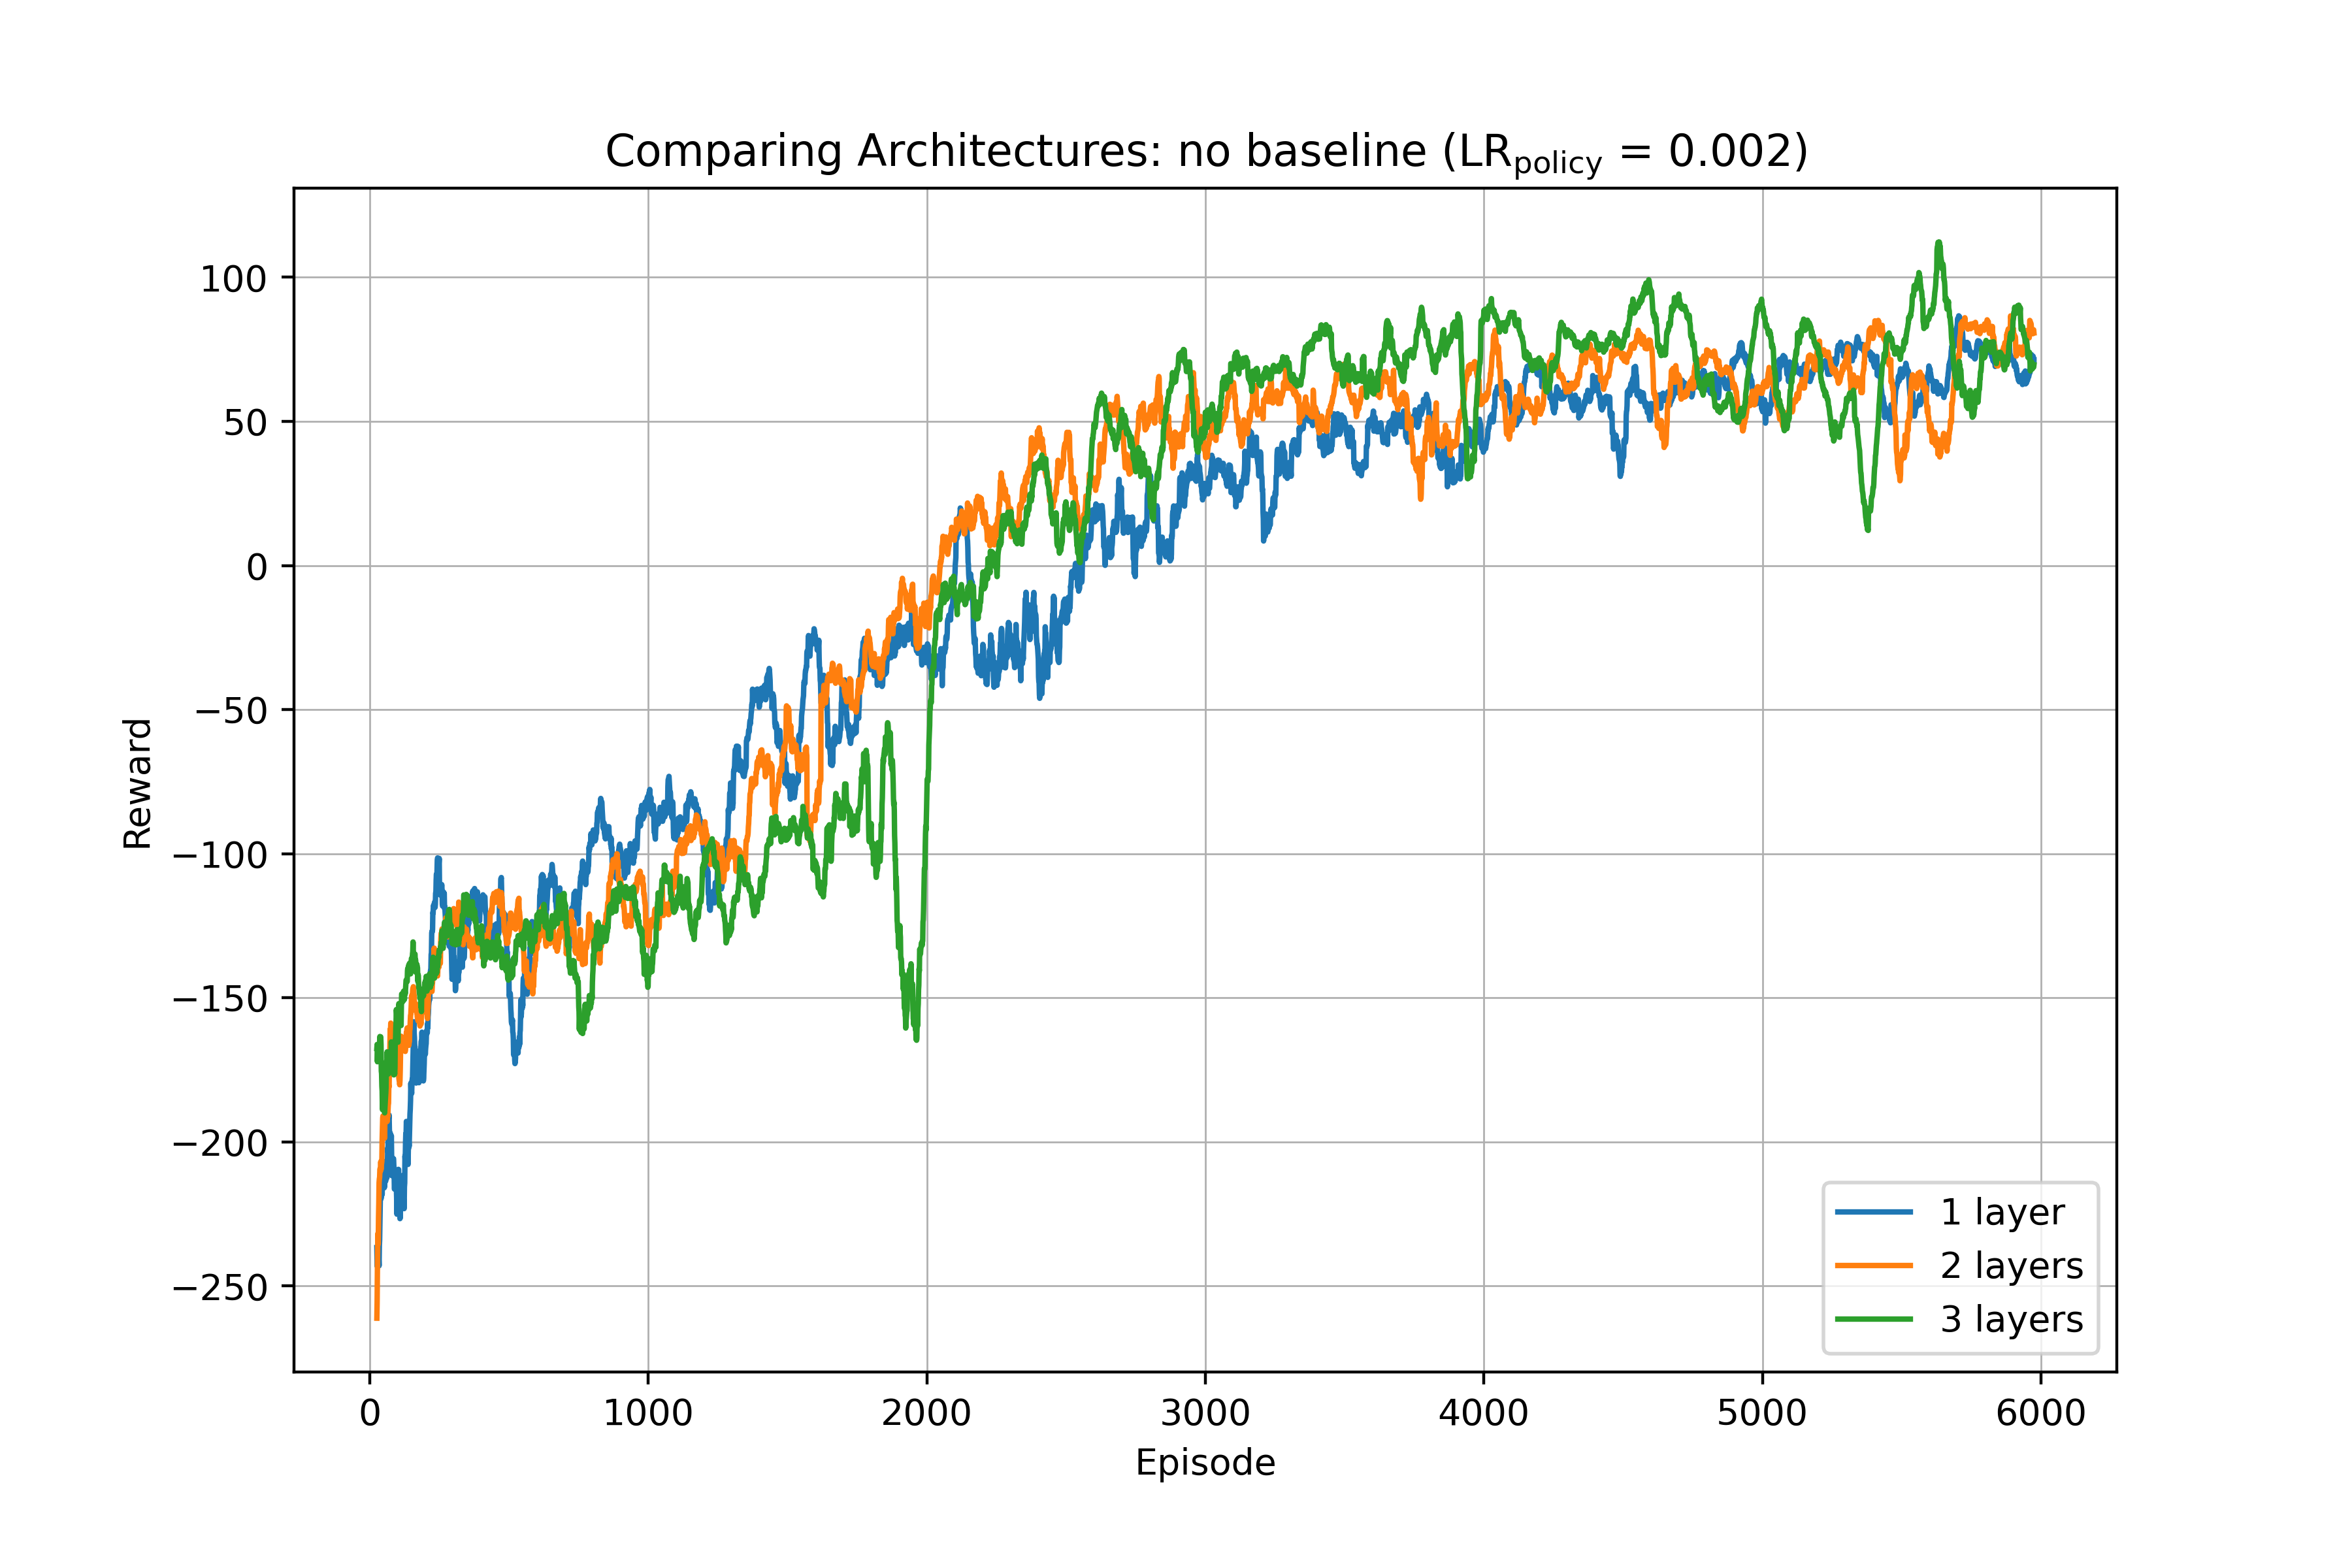

*Description of the above figure*: Comparison between the different architectures for the no baseline case with a learning rate of 0.002. The architectures demonstrate very similar performance over the span of 6000 episodes. The learning rate (lr) used is the optimal one (i.e the best found by visual inspection) found in exercise 1 with 3 layers. To go further, one could search for the best lr for each architecture, since they do not have the same number of network parameters to optimize.  
Convolutional window used: 50 (i.e the call to the plot function is `results.plot(50)`).

**Simple baseline:**
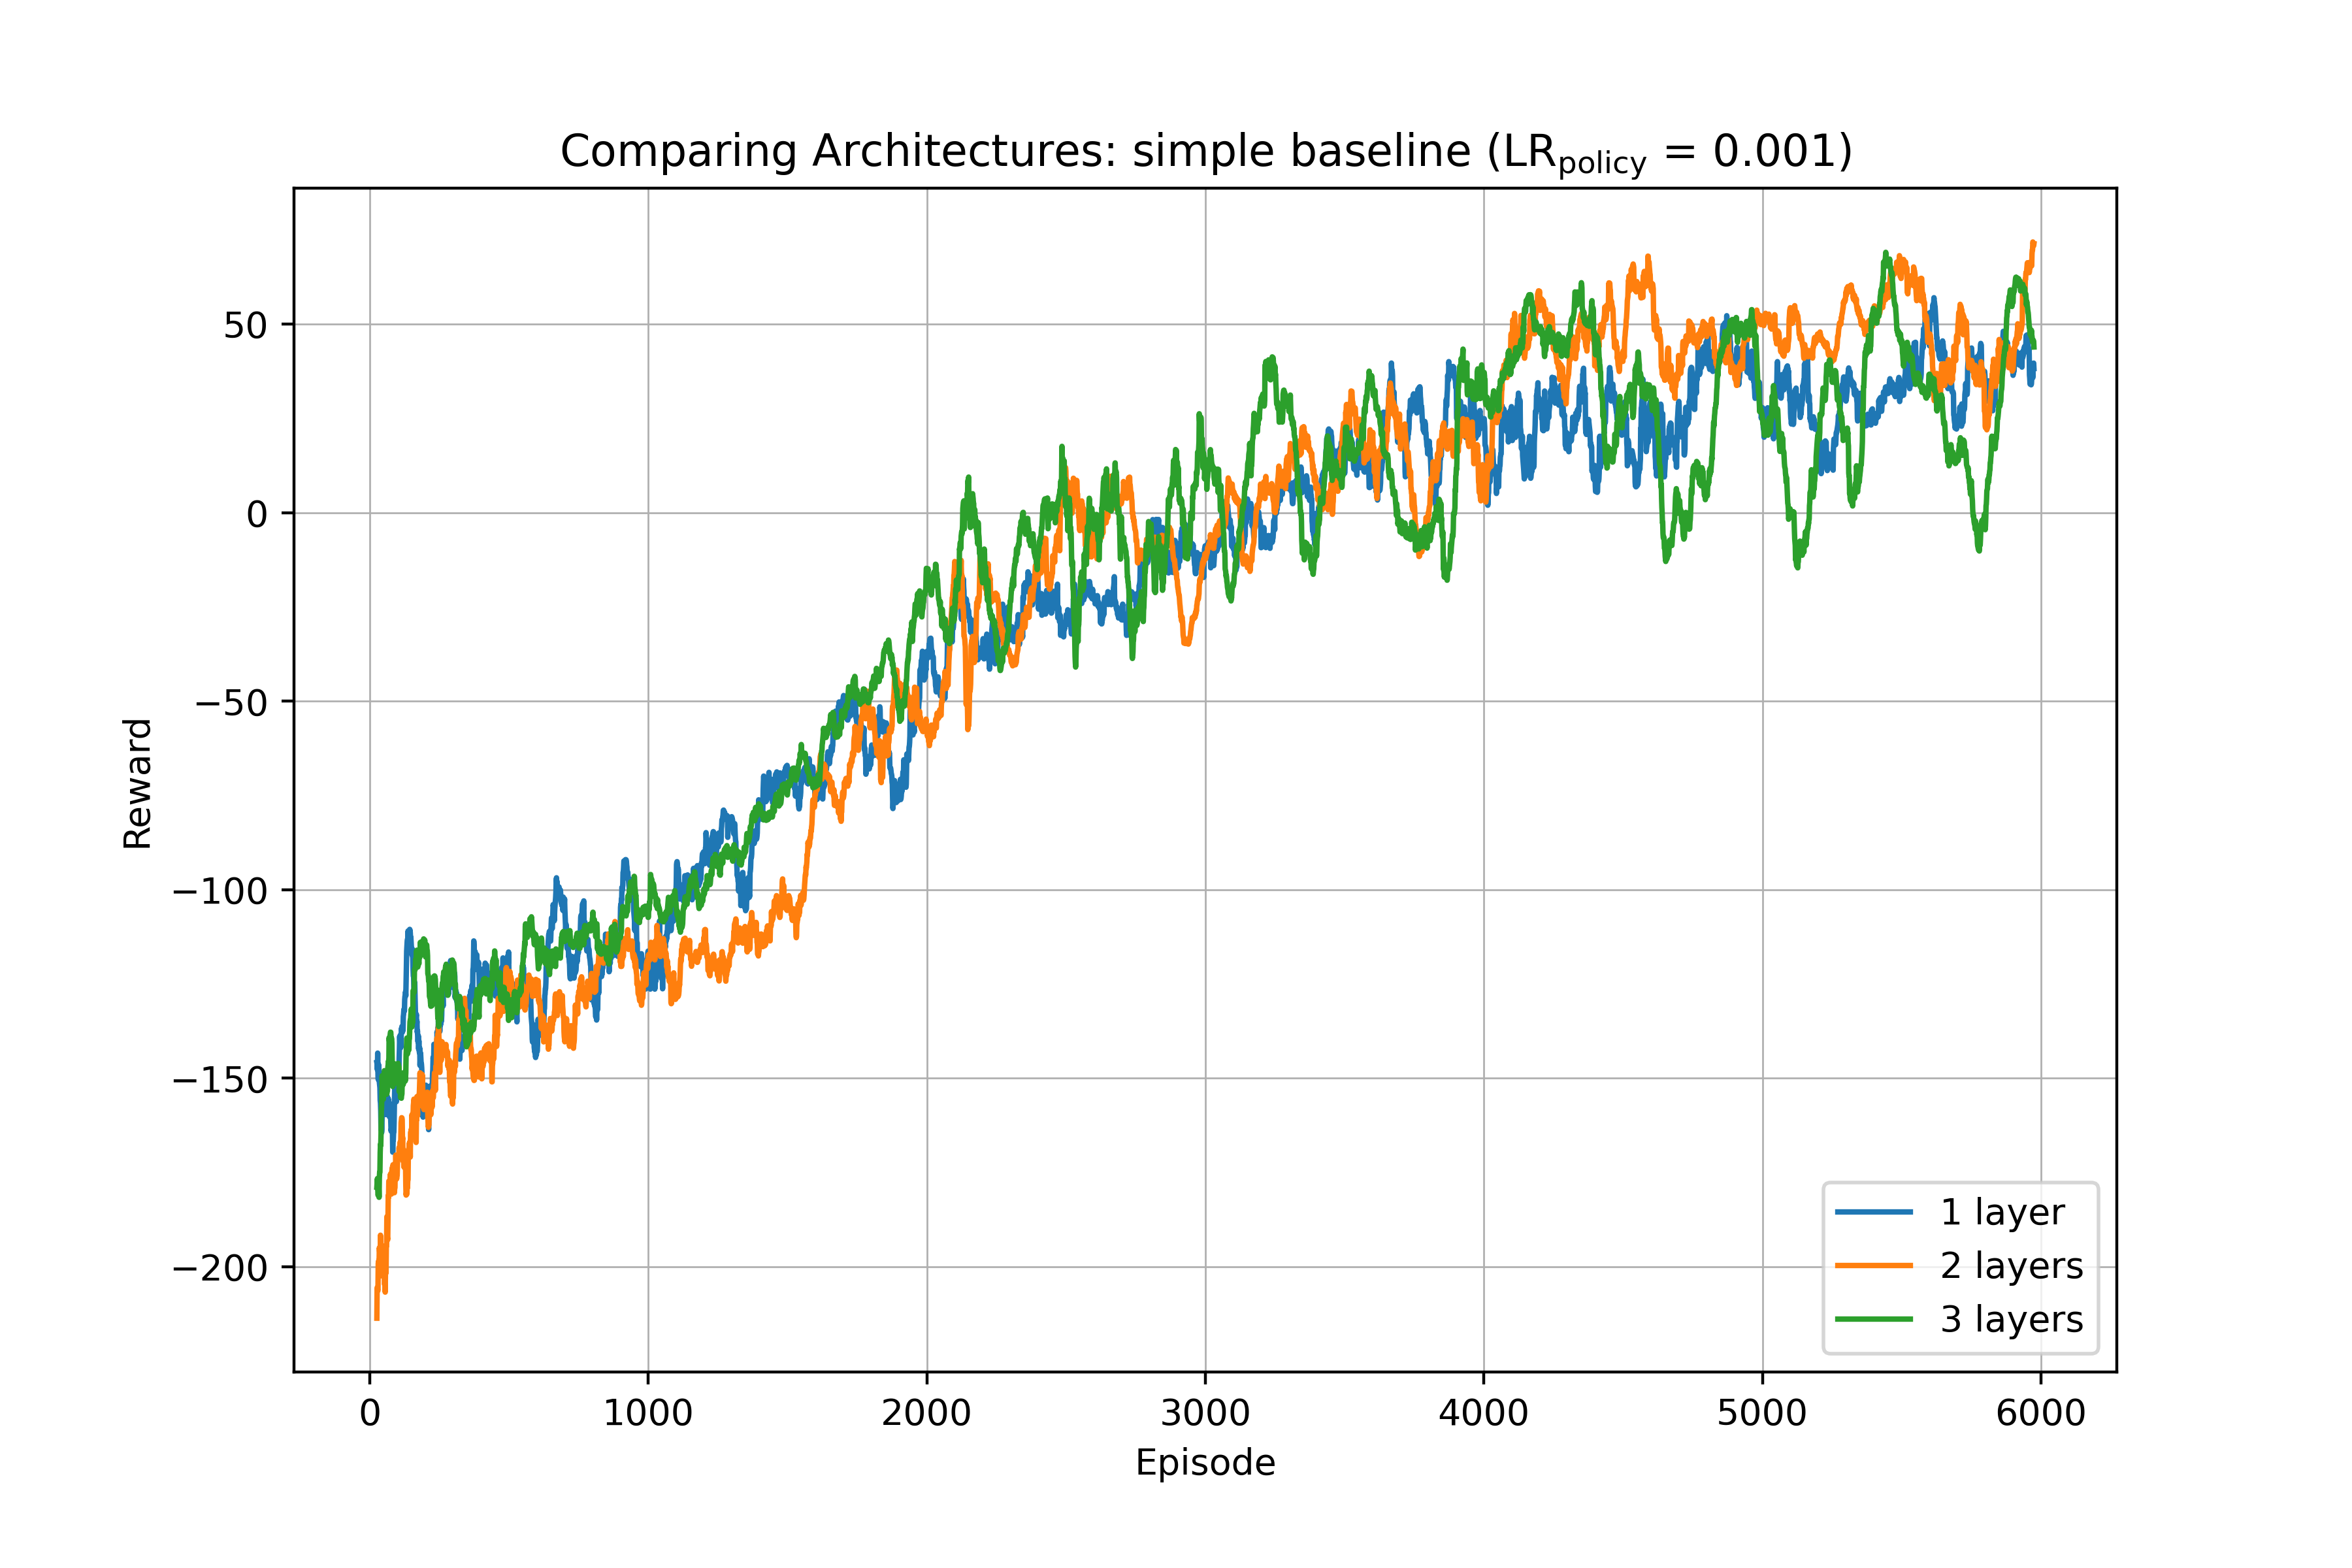

*Description of the above figure*: Comparison between the different architectures for the simple baseline case with a learning rate of 0.001. Here again, the architectures demonstrate very similar performance over the span of 6000 episodes. The fluctuations at the end (5000 episode and more) are more important as the number of layers increases.   
This could be interpreted as the fact that the ratio (# episodes) / (# network parameters) increases as well.   
Convolutional window used: 50 (i.e the call to the plot function is `results.plot(50)`).

**Adaptive baseline:**
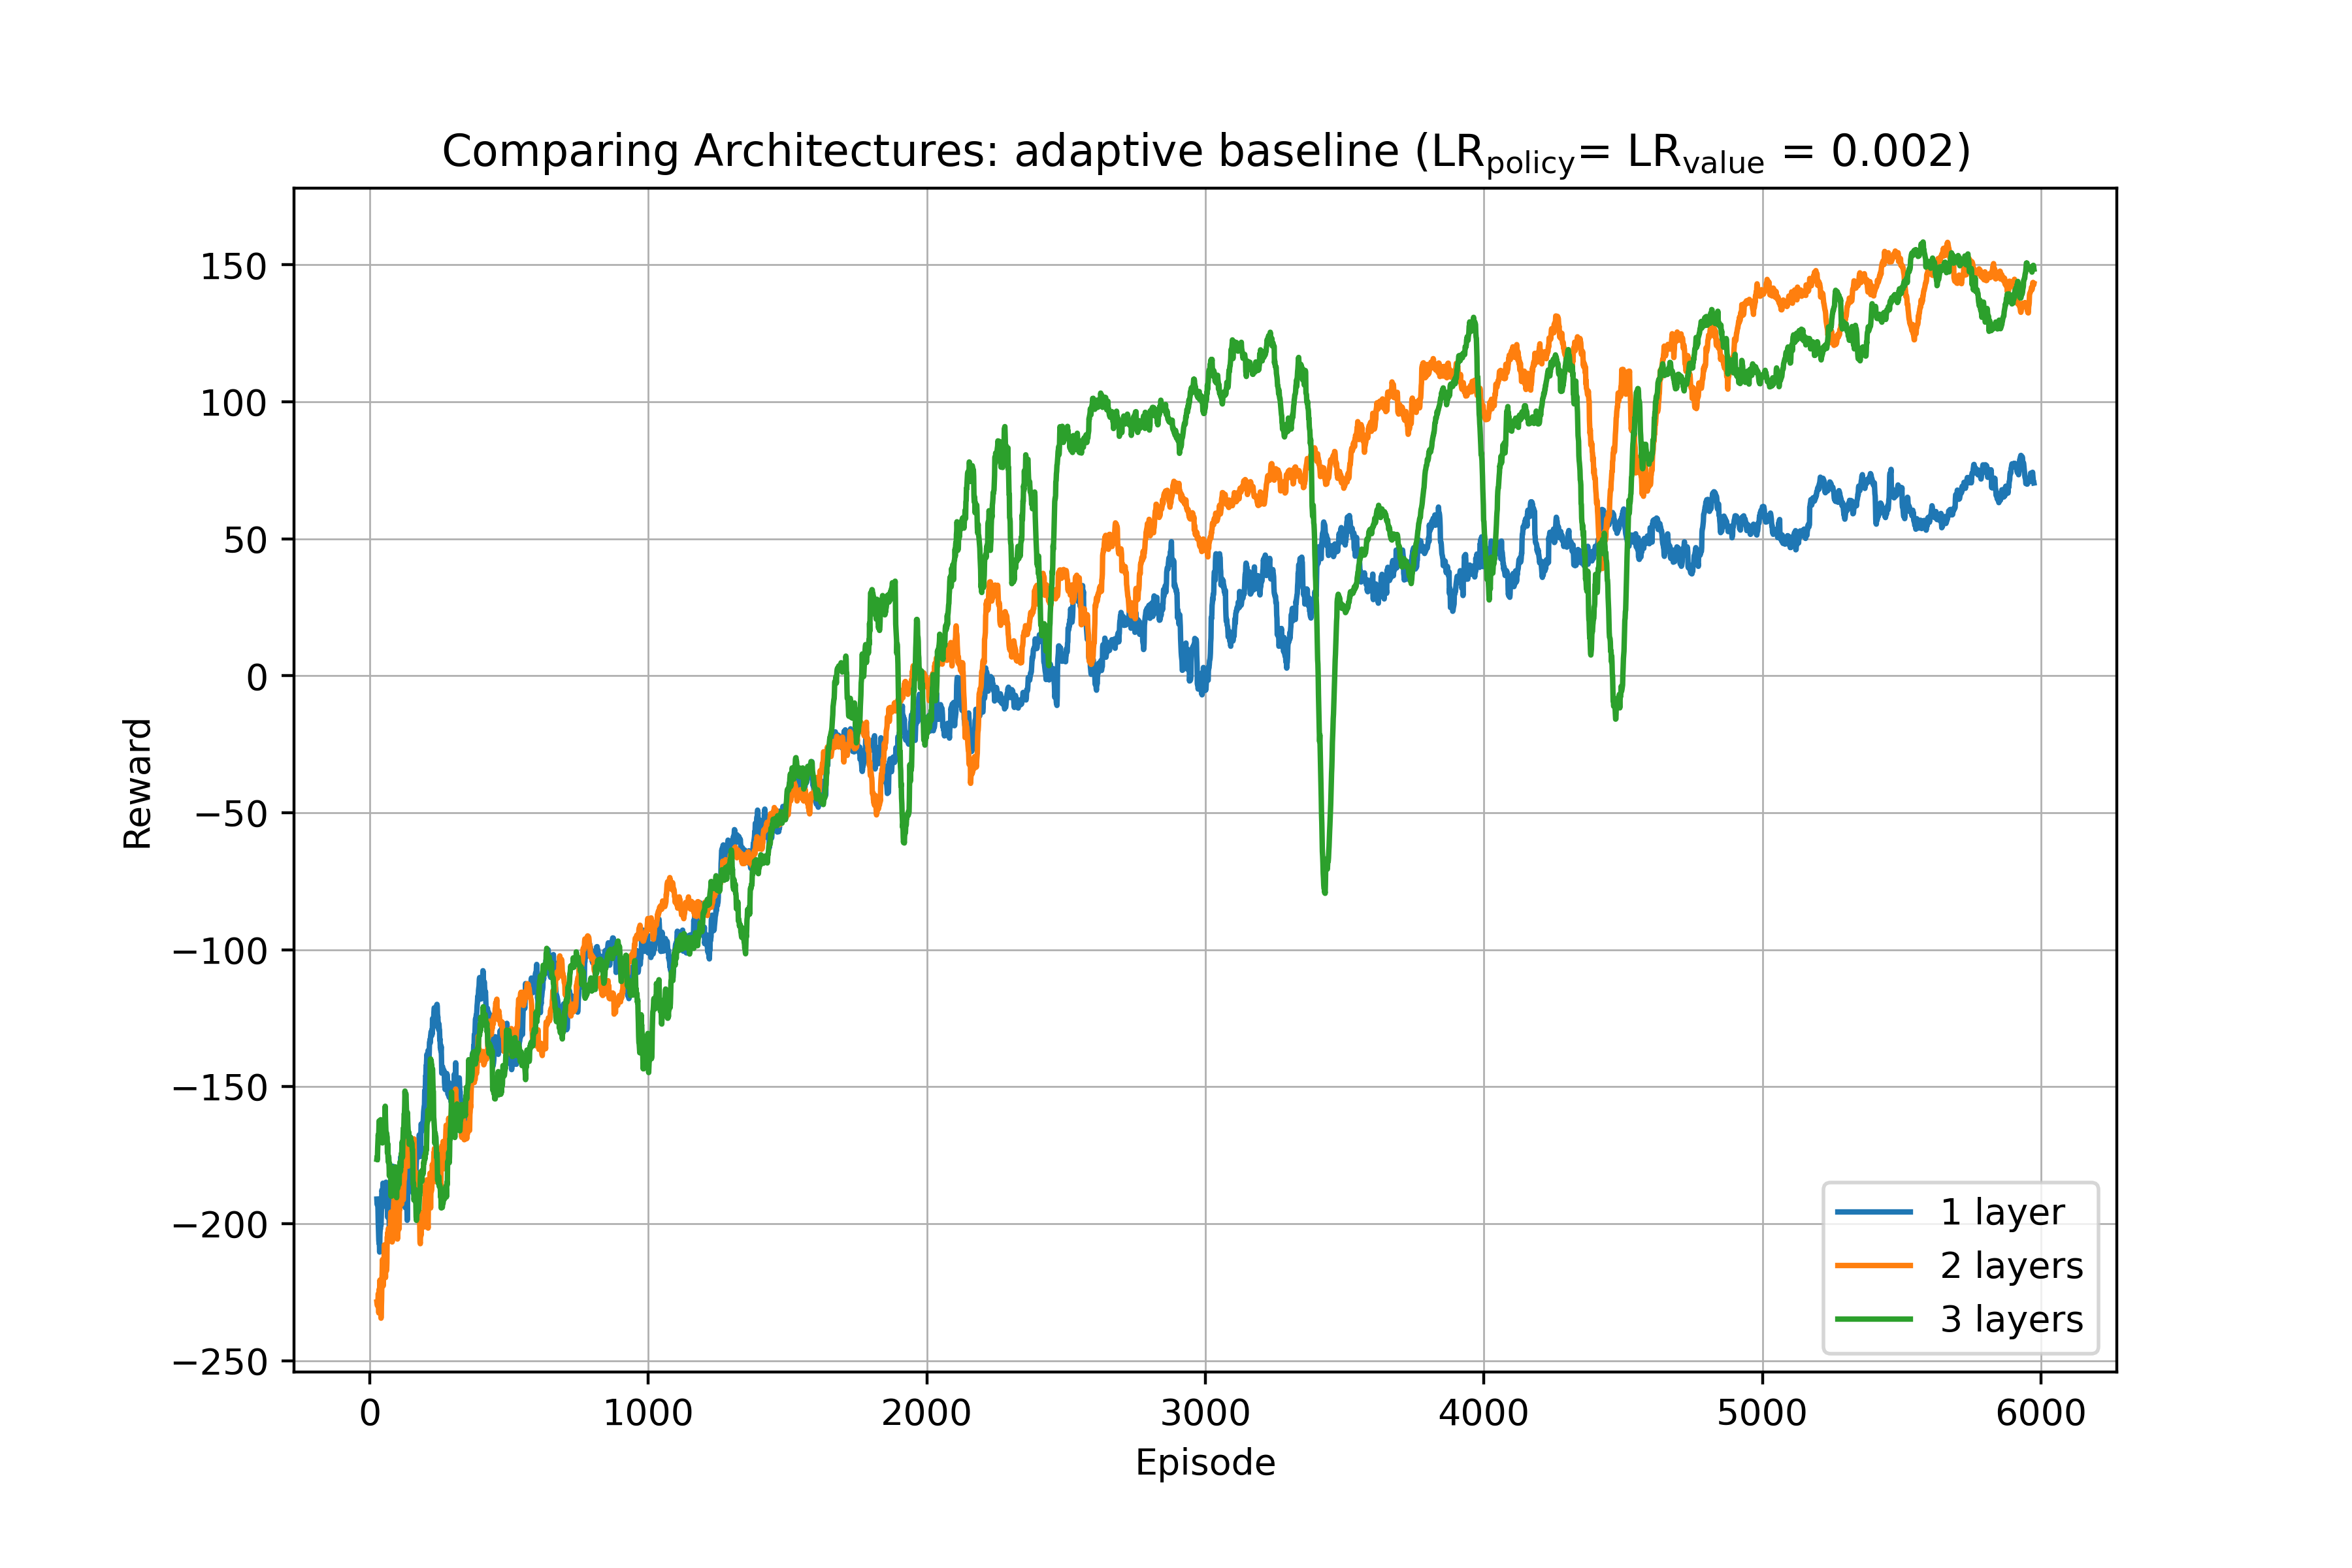

*Description of the above figure*: Comparison between the different architectures for the adaptive baseline case with a value and policy learning rates of 0.002. When 'n layers' is specified, it means that both the policy and value models are implemented with n hidden layers.  
In this case, we observe a significant difference between 1 layer and 2+ layers. It is interesting to see that at episode 3000, the 3 layers agent performs better that the 2 layers one, which itself outperforms the 1 layer agent. However, at episode 6000, the 2 and 3 layers agents have very similar performance.  
Convolutional window used: 50 (i.e the call to the plot function is `results.plot(50)`).